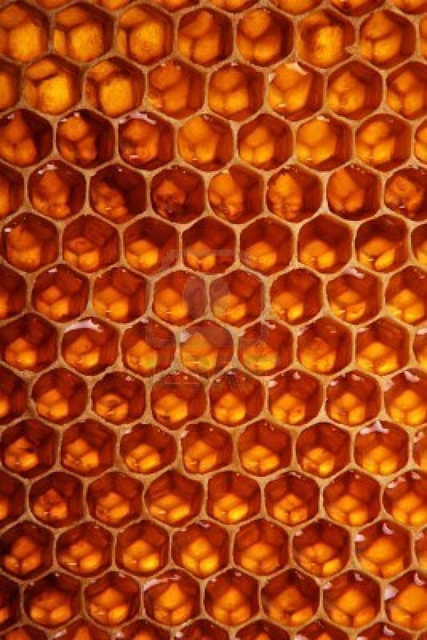

In [1]:
import os 
from PIL import Image

# Exemplar image
exemplar_path = os.path.join("exemplars", "images", "honeycombed_0003.jpg")
display(Image.open(exemplar_path))

#### (Optional) launch visdom server in a separate shell with the following command
visdom -port 8095

In [2]:
# configurations 
from configs.default import opt
import utils.io as io

config = {
    "experiment_id": "notebook_demo",   
    "dataset" :
    {        
         "path": exemplar_path,
    },
    "model":
    {
        "latent_dim":5,
    },
    "visdom":
    {
        "display_id": 1, # changed to -1 if not running visdom
        "port": 8095,
    },
    "run_mode": "train",
    "gpu_id": 0,
}

opt = io.process_args(opt, config)

In [3]:
# initialize trainer
from core.trainer import IPFNTrainer
trainer = IPFNTrainer(opt)

#22-10-03 00:09:51# [Setup] Logger created! Hello World!
#22-10-03 00:09:51# [Setup] Random seed has been set to 666
#22-10-03 00:09:51# [Setup] Experiment id: notebook_demo
#22-10-03 00:09:51# [Setup] Model id: model_20221003_00:09:51
#22-10-03 00:09:51# [Setup] Checkpoint dir created!
DATASET SAMPLES LOADED. LENGTH:  20000
[Dataset] choosing a scale factor of 3.3359375!!!
[Dataset] Input original size at [640, 427], which is cropped to 128!!!
Using network model vanilla_mlp!
Using discriminator model vanilla_netD!
#22-10-03 00:09:54# [Setup] Setup optimizer!
#22-10-03 00:09:54# [Setup] Optimizer all-set!
#22-10-03 00:09:54# [Setup] Seems like we train from scratch!
#22-10-03 00:09:54# [Setup] Using Single-gpu!
#22-10-03 00:09:54# [Setup] Setup finished!


Setting up a new session...


Showing cropped patches of size 128x128


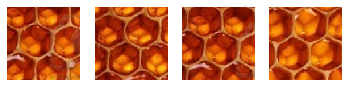

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def to_numpy_image(x):
    x = 255 / 2 * (x.numpy().transpose(1,2,0) + 1)
    return x.astype(np.int32)

%matplotlib inline
# verifying training patches
patches = next(trainer.dataset_iter)[0]
print(f"Showing cropped patches of size {patches.shape[2]}x{patches.shape[3]}")
nb = min(patches.shape[0],4)
_, ax = plt.subplots(1,nb) 
for i in range(nb):
    ax[i].axis('off')
    ax[i].imshow(to_numpy_image(patches[i]))

In [ ]:
# (optional) training from scratch
trainer.opt.run_mode = "train"
num_epochs = 60
trainer.train_epoch(num_epochs)

If visdom is enabled, navigate to <localhost:8095> for monitoring training progress

In [5]:
# (optional) load pretrained checkpoints
trainer.opt.run_mode = "eval"
ckpt_path = os.path.join("exemplars","ckpt","honeycomb_test_netG_Epoch101.pth")
trainer._resume_from_ckpt(ckpt_path)

#22-10-03 00:10:01# [Setup] Resume from checkpoint: exemplars/ckpt/honeycomb_test_netG_Epoch101.pth
#22-10-03 00:10:01# [Setup] Resume finished! Great!


(optional) If visdom is enabled, run the following block and navigate to <localhost:8095> for viewing the evaluation results

In [ ]:
trainer.eval()

Showing synthesized pattern at 6X scale:


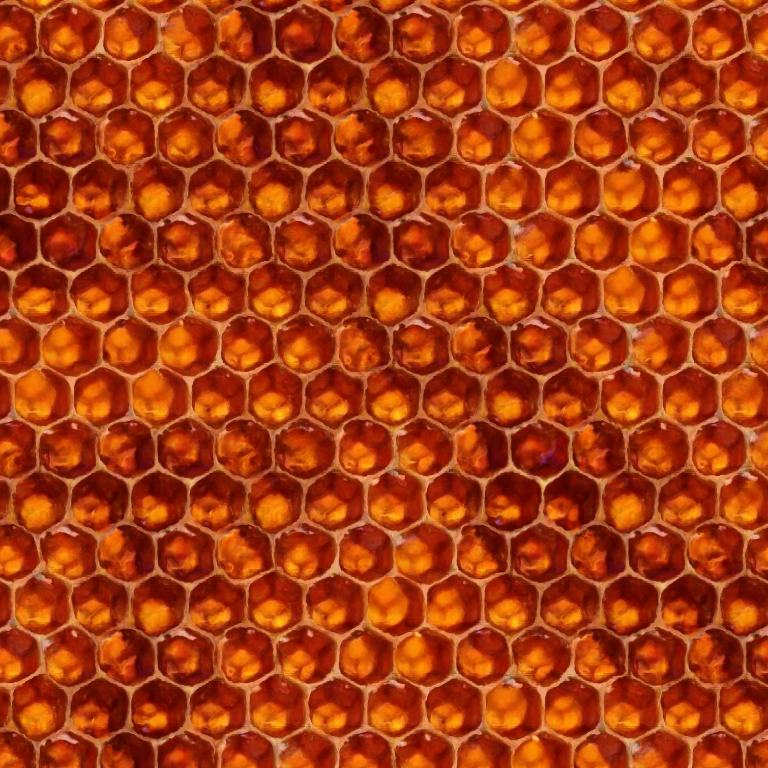

In [6]:
import utils.helper as H
import utils.visualizer as V
import torch

scale = 6
with torch.no_grad():
    g_in = H._get_input(int(scale * trainer.crop_size), trainer.dist_shift, trainer.opt, scale=scale)
    recon, z = trainer.modelG(g_in, noise_factor=trainer.opt.model.noise_factor)
    recon_img = to_numpy_image(recon[0].detach().cpu())

print(f"Showing synthesized pattern at {scale}X scale:")
display(Image.fromarray(np.uint8(recon_img)))